## Steup

### imports and globals

In [1]:
!pip install ucimlrepo # for downloading the Parkinsons Telemonitoring dataset

In [2]:
# general
import cupy as np
from cupy.linalg import norm
from numpy import geomspace
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

# datasets access
from sklearn.datasets import fetch_california_housing
from ucimlrepo import fetch_ucirepo
from sklearn.datasets import fetch_openml

# data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
seeds = range(2048,2058)

### helper classes

In [4]:
# class representing a stepsize configuration
# stepsize is of the form $\eta \alpha$,
# where $\alpha$ is the clipping operator
class Params:
    def __init__(self, num_grads_per_step=1, name="[param]", plot_color="tab:blue"):
        self.num_grads_per_step = num_grads_per_step
        self.name = name
        self.plot_color = plot_color

    def prepare_for_run(self):
        pass

    def eta(self, g, dbl_g):
        raise NotImplementedError

    def alpha(self, g, dbl_g):
        raise NotImplementedError

    def is_clipped(self, g, dbl_g):
        raise NotImplementedError

    def stepsize(self, g, dbl_g):
        return self.eta(g, dbl_g) * self.alpha(g, dbl_g)

    def __call__(self, g, dbl_g):
        return self.stepsize(g, dbl_g)

In [5]:
class SGD(Params):
    def __init__(self, lr=1, name="[param]"):
        self.lr = lr
        self.c = None
        super().__init__(num_grads_per_step=1, name=name, plot_color="tab:blue")

    def eta(self, g, dbl_g):
        return self.lr

    def alpha(self, g, dbl_g):
        return 1

    def is_clipped(self, g, dbl_g):
        return False

In [6]:
class ClippedSGD(Params):
    def __init__(self, lr=1, c=1, name="[param]"):
        self.lr = lr
        self.c = c
        super().__init__(num_grads_per_step=2, name=name, plot_color="tab:blue")

    def eta(self, g, dbl_g):
        return self.lr

    def alpha(self, g, dbl_g):
        if norm(dbl_g) == 0:
            return 1
        return min(1, self.c / norm(dbl_g))

    def is_clipped(self, g, dbl_g):
        return (norm(dbl_g) > self.c)

In [7]:
class ImplicitlyClippedSGD(Params):
    def __init__(self, lr=1, c=1, name="[param]"):
        self.lr = lr
        self.c = c
        super().__init__(num_grads_per_step=2, name=name, plot_color="tab:orange")

    def eta(self, g, dbl_g):
        return self.lr * self.c / (self.c + norm(dbl_g))

    def alpha(self, g, dbl_g):
        return 1

    def is_clipped(self, g, dbl_g):
        return (norm(dbl_g) > self.c)

In [8]:
class ClippedSGDSingleSample(Params):
    def __init__(self, lr=1, c=1, name="[param]"):
        self.lr = lr
        self.c = c
        super().__init__(num_grads_per_step=1, name=name, plot_color="tab:purple")

    def eta(self, g, dbl_g):
        return self.lr

    def alpha(self, g, dbl_g):
        if norm(g) == 0:
            return 1
        return min(1, self.c / norm(g))

    def is_clipped(self, g, dbl_g):
        return (norm(g) > self.c)

In [9]:
class AdaptiveSGD(Params):
    def __init__(self, lr=1, name="[param]"):
        self.lr = lr
        self.c = None
        self.G = 1e-5
        super().__init__(num_grads_per_step=1, name=name, plot_color="tab:green")

    def prepare_for_run(self):
        self.G = 1e-5

    def eta(self, g, dbl_g):
        self.G += np.power(norm(g), 2)
        return self.lr / np.sqrt(self.G)

    def alpha(self, g, dbl_g):
        return 1

    def is_clipped(self, g, dbl_g):
        return False

In [10]:
class ClippedAdaptiveSGD(Params):
    def __init__(self, lr=1, c=1, name="[param]"):
        self.lr = lr
        self.c = c
        self.G = 1e-5
        super().__init__(num_grads_per_step=2, name=name, plot_color="tab:green")

    def prepare_for_run(self):
        self.G = 1e-5

    def eta(self, g, dbl_g):
        self.G += np.power(self.alpha(g, dbl_g) * norm(g), 2)
        return self.lr / np.sqrt(self.G)

    def alpha(self, g, dbl_g):
        if norm(dbl_g) == 0:
            return 1
        return min(1, self.c / norm(dbl_g))

    def is_clipped(self, g, dbl_g):
        return (norm(dbl_g) > self.c)

In [11]:
# not in use anymore
class Function:
    def __init__(self, val_func, grad_func):
        self.val = val_func
        self.grad = grad_func

    def __call__(self, x):
        return self.val(x)

### data setup

In [12]:
# california housing dataset
df = fetch_california_housing(as_frame=True).frame
X = df.drop(columns=['MedHouseVal'])
y = df['MedHouseVal']

In [13]:
# # parkinson's telemonitoring dataset
# parkinsons_telemonitoring = fetch_ucirepo(id=189)
# X = parkinsons_telemonitoring.data.features.drop(columns=['sex'])
# y = parkinsons_telemonitoring.data.targets['motor_UPDRS']

In [14]:
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    # ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

X = preprocessor.fit_transform(X)
X = np.c_[np.ones(X.shape[0]), X] # to simulate a bias parameter for the regression

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).reshape(-1)
y = y_scaled

# Convert NumPy arrays to CuPy arrays (notice i imported cupy as np)
X = np.array(X)
y = np.array(y)

# shuffle samples (so tuning won't use the original order)
# the initial shuffling is only used for tuning. the plots
# are based on training that uses the global seeds list
np.random.seed(seed=1234)
indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]

### loss function setup

In [15]:
def loss_func(w, X, y):
    # regular loss
    if w.ndim == 1:
        return (1 / y.shape[0]) * np.power(norm(X.dot(w) - y),4)
    # simultaneously compute loss on multiple points (e.g., an algorithm's iterates)
    else:
        loadable_size = 10000
        loss_vecs = []
        for start_idx in range(0, w.shape[0], loadable_size):
            end_idx = min(start_idx + loadable_size, w.shape[0])
            w_batch = w[start_idx:end_idx]

            diff_vec_batch = X.dot(w_batch.T) - y.reshape(-1, 1)
            loss_vec_batch = np.power(norm(diff_vec_batch, axis=0),4)

            loss_vecs.append(loss_vec_batch)

        return  (1 / y.shape[0]) * np.concatenate(loss_vecs)


def loss_grad(w, X, y, i=None):
    """
    Compute the gradient of L(w) = ‖Xw − y‖⁴ with respect to w.
    Explenation of the formula used in the code:
    Denote
      • r = Xw − y
      • ℓ_i(w) = r_i²·‖r‖²
    Then
      L(w) = ‖r‖⁴ = (‖r‖²)² = (∑_{i=1}^N r_i²)²
           = ∑_{i=1}^N ∑_{j=1}^N r_i² r_j²
           = ∑_{i=1}^N [r_i² (∑_{j=1}^N r_j²)]
           = ∑_{i=1}^N r_i² ‖r‖²
           = ∑_{i=1}^N ℓ_i(w)

    By the product rule,
      ∇ℓ_i(w) = (∇r_i^2)·‖r‖² + (r_i^2)·∇‖r‖²
              = 2 r_i (∇r_i) ‖r‖² + 2 (r_i^2) r (∇r)
              = 2 r_i X_iᵀ ‖r‖²  + 2 (r_i^2) r Xᵀ
              = 2 [‖r‖² r_i X_iᵀ + (r_i^2) Xᵀr]
    """
    diff = (X.dot(w) - y)
    diff_norm_squared = np.square(norm(diff))
    if i == None:
        grad = (1 / y.shape[0]) * 4 * diff_norm_squared * (X.T @ diff)
    else:
        i = i % y.shape[0]
        grad = 2 * (diff[i] * diff_norm_squared * X[i].T + diff[i]**2 * np.sum(diff[:, np.newaxis] * X, axis=0))
        grad = np.array(grad)
    return grad

In [16]:
# # sanity check for gradient computation

# x_0      = np.random.RandomState(42).randn(X.shape[1])
# x_0      = x_0 / norm(x_0)

# grads_across_i = np.array([func.grad(x_0,i) for i in range(X.shape[0])])
# np.all(np.absolute(func.grad(x_0) - np.mean(grads_across_i, axis=0)) < 1e-5)

### optimization and plotting functions

In [17]:
def optimize_reg(x_0, X, y, func: Function, params: Params, T, use_tqdm=False, with_iterates=False, opt=None):
    x_t = np.array(x_0)
    params.prepare_for_run()
    iterates, averages, tau_2_iterates, tau_2_averages, grads = [], [], [], [], []

    iter = tqdm.tqdm(range(0,T,params.num_grads_per_step)) if use_tqdm else range(0,T,params.num_grads_per_step)
    for t in iter:
        # compute grads
        g_t     = loss_grad(x_t, X, y, 2*t)
        dbl_g_t = loss_grad(x_t, X, y, 2*t+1)

        # maintain the five lists
        grads.append(g_t)
        iterates.append(x_t)
        averages.append(np.mean(np.array(iterates), axis=0))

        if not params.is_clipped(g_t, dbl_g_t):
            tau_2_iterates.append(x_t)

        if len(tau_2_iterates) == 0:
            tau_2_averages.append(x_0)
        else:
            tau_2_averages.append(np.mean(np.array(tau_2_iterates), axis=0))

        # step
        x_t = x_t - params(g_t, dbl_g_t) * g_t

    if opt == None:
        opt = np.array(0.0)

    if with_iterates:
        return (
            loss_func(np.array(iterates), X, y) - opt,
            loss_func(np.array(averages), X, y) - opt,
            loss_func(np.array(tau_2_averages), X, y) - opt,
            norm(np.array(grads), axis=1),
            np.array(iterates)
        )
    else:
        return (
            loss_func(np.array(iterates), X, y) - opt,
            loss_func(np.array(averages), X, y) - opt,
            loss_func(np.array(tau_2_averages), X, y) - opt,
            norm(np.array(grads), axis=1),
        )

In [18]:
from numpy import median, percentile

def optimize_multiple_seeds(x_0, X, y, func: Function, params: Params, T, use_tqdm=False, with_iterates=False, opt=None):
    results = []
    iter = tqdm.tqdm(seeds) if use_tqdm else seeds
    for seed in iter:
        np.random.seed(seed=seed)

        indices = np.random.permutation(len(X))
        X = X[indices]
        y = y[indices]

        result = optimize_reg(x_0, X, y, func, params, T, use_tqdm=False, with_iterates=with_iterates, opt=opt)
        results.append(result)

        inv_indices = np.argsort(indices)
        X = X[inv_indices]
        y = y[inv_indices]

    regular_iterates_med     = np.median(np.array([res[0] for res in results if not np.isnan(res[0][-1])]), axis=0)
    average_iterates_med     = np.median(np.array([res[1] for res in results if not np.isnan(res[1][-1])]), axis=0)
    tau2average_iterates_med = np.median(np.array([res[2] for res in results if not np.isnan(res[2][-1])]), axis=0)
    grad_norm_med            = np.median(np.array([res[3] for res in results if not np.isnan(res[3][-1])]), axis=0)

    regular_iterates_bottom     = np.percentile(np.array([res[0] for res in results if not np.isnan(res[0][-1])]), 25, axis=0)
    average_iterates_bottom     = np.percentile(np.array([res[1] for res in results if not np.isnan(res[1][-1])]), 25, axis=0)
    tau2average_iterates_bottom = np.percentile(np.array([res[2] for res in results if not np.isnan(res[2][-1])]), 25, axis=0)
    grad_norm_bottom            = np.percentile(np.array([res[3] for res in results if not np.isnan(res[3][-1])]), 25, axis=0)

    regular_iterates_top     = np.percentile(np.array([res[0] for res in results if not np.isnan(res[0][-1])]), 75, axis=0)
    average_iterates_top     = np.percentile(np.array([res[1] for res in results if not np.isnan(res[1][-1])]), 75, axis=0)
    tau2average_iterates_top = np.percentile(np.array([res[2] for res in results if not np.isnan(res[2][-1])]), 75, axis=0)
    grad_norm_top            = np.percentile(np.array([res[3] for res in results if not np.isnan(res[3][-1])]), 75, axis=0)

    return ((regular_iterates_med, regular_iterates_bottom, regular_iterates_top), \
            (average_iterates_med, average_iterates_bottom, average_iterates_top), \
            (tau2average_iterates_med, tau2average_iterates_bottom, tau2average_iterates_top), \
            (grad_norm_med, grad_norm_bottom, grad_norm_top))

In [19]:
def plot_with_shaded_region(x, med, bottom, top, label, ax=None, color=None, linestyle='solid'):
    if color == None:
        if ax != None:
            ax.plot(x, med, label=f"{label}", linestyle=linestyle)
            ax.fill_between(x, bottom, top, alpha=0.2, linestyle=linestyle)
        else:
            plt.plot(x, med, label=f"{label}", linestyle=linestyle)
            plt.fill_between(x, bottom, top, alpha=0.2, linestyle=linestyle)
    else:
        if ax != None:
            ax.plot(x, med, label=f"{label}", color=color, linestyle=linestyle)
            ax.fill_between(x, bottom, top, alpha=0.2, color=color, linestyle=linestyle)
        else:
            plt.plot(x, med, label=f"{label}", color=color, linestyle=linestyle)
            plt.fill_between(x, bottom, top, alpha=0.2, color=color, linestyle=linestyle)

In [20]:
def plot_global_config(xlabel_name, xlabel_fs, ylabel_name, ylabel_fs, legend_fs, filename):
    plt.yscale("log")
    plt.xlabel(xlabel_name, fontsize=xlabel_fs)
    plt.ylabel(ylabel_name, fontsize=ylabel_fs)
    plt.legend(fontsize=legend_fs)
    plt.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0.025)

### tuning functions

In [21]:
def grid_search_reg(func, params, grid, T, has_threshold, verbose=False, criteria=2):
    results = []
    iter = grid if verbose else tqdm.tqdm(grid)

    if has_threshold:
        for lr,c in iter:
            if verbose:
                print(f"    testing lr={lr:.1e} c={c:.1e}...", end=" ")
            params.lr = lr
            params.c = c
            result = optimize_reg(x_0, X, y, func, params, T)
            results.append(result[criteria][-1])
            if verbose:
                print(f"    result: {result[criteria][-1]:.3e}")
    else:
        for lr in iter:
            if verbose:
                print(f"    testing lr={lr:.1e}...", end=" ")
            params.lr = lr
            result = optimize_reg(x_0, X, y, func, params, T)
            results.append(result[1][-1])
            if verbose:
                print(f"    result: {result[1][-1]:.3e}")

    return np.array(results)

In [22]:
def tune_reg(func, params, T, has_threshold, grid_lr, grid_c=None, verbose=False, criteria=2):
    print(f"tuning {params.name}...")

    coarse_grid_lr = grid_lr
    coarse_grid_c  = grid_c
    if has_threshold:
        coarse_grid    = np.array(np.meshgrid(coarse_grid_lr, coarse_grid_c)).T.reshape(-1, 2)
    else:
        coarse_grid    = coarse_grid_lr

    coarse_results = grid_search_reg(func, params, coarse_grid, T, has_threshold, verbose=verbose, criteria=criteria)
    coarse_results = coarse_results[~np.isnan(coarse_results)]
    best           = coarse_grid[np.argmin(coarse_results)]
    if has_threshold:
        print(f"    best (lr,c) from coarse search: ({best[0]:.1e},{best[1]:.1e})")
    else:
        print(f"    best (lr) from coarse search: ({best:.1e})")

    if has_threshold:
        fine_grid_lr = np.array(geomspace(best[0].get() / 4, best[0].get() * 4, 5))
        fine_grid_c  = np.array(geomspace(best[1].get() / 4, best[1].get() * 4, 5))
        fine_grid    = np.array(np.meshgrid(fine_grid_lr, fine_grid_c)).T.reshape(-1, 2)
    else:
        fine_grid = np.array(geomspace(best.get() / 4, best.get() * 4, 5))

    fine_results = grid_search_reg(func, params, fine_grid, T, has_threshold, verbose=verbose, criteria=criteria)
    fine_results = fine_results[~np.isnan(fine_results)]
    best         = fine_grid[np.argmin(fine_results)]
    if has_threshold:
        print(f"    best (lr,c) from fine search: ({best[0]:.1e},{best[1]:.1e})")
    else:
        print(f"    best (lr) from fine search: ({best:.1e})")

    if has_threshold:
        params.lr = best[0]
        params.c = best[1]
    else:
        params.lr = best

### experiment parameter setup

In [23]:
T          = int(2e03)
x_0        = np.random.RandomState(42).randn(X.shape[1])
x_0        = x_0 / norm(x_0)
resolution = 10
func       = None # ugly patching after removing its original value

In [24]:
# for an estimation of the optimum (which is used to plot the
# optimality gap), we compute our loss on sklearn's result

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
npX, npy = np.asnumpy(X), np.asnumpy(y)
lin_reg.fit(npX, npy)
y_pred = lin_reg.predict(npX)
loss_scikit = (1 / y.shape[0]) * np.power(norm(y_pred - npy), 4)
print("loss of sklearn's regression module output:", loss_scikit)

loss of sklearn's regression module output: 3200.287690950287


## Experiments

### comparison of different step sizes

In [25]:
params_list = [
    ClippedSGD(name="standard clipping"),
    ImplicitlyClippedSGD(name="implicit clipping"),
    ClippedAdaptiveSGD(name="adaptive clipping"),
]
tune_reg(func,
         params_list[0],
         T,
         grid_lr=np.array(geomspace(1e-7, 1e-2, 6)),
         grid_c=np.array(geomspace(1e02, 1e07, 6)),
         has_threshold=True,
         verbose=False)
tune_reg(func,
         params_list[1],
         T,
         grid_lr=np.array(geomspace(1e-7, 1e-2, 6)),
         grid_c=np.array(geomspace(1e02, 1e07, 6)),
         has_threshold=True,
         verbose=False)
tune_reg(func,
         params_list[2],
         T,
         grid_lr=np.array(geomspace(1e-2, 1e03, 6)),
         grid_c=np.array(geomspace(1e02, 1e07, 6)),
         has_threshold=True,
         verbose=False)

tuning standard clipping...


100%|██████████| 36/36 [01:25<00:00,  2.37s/it]


    best (lr,c) from coarse search: (1.0e-06,1.0e+05)


100%|██████████| 25/25 [01:02<00:00,  2.48s/it]


    best (lr,c) from fine search: (4.0e-06,2.5e+04)
tuning implicit clipping...


100%|██████████| 36/36 [01:10<00:00,  1.97s/it]


    best (lr,c) from coarse search: (1.0e-05,1.0e+04)


100%|██████████| 25/25 [00:50<00:00,  2.03s/it]


    best (lr,c) from fine search: (5.0e-06,2.0e+04)
tuning adaptive clipping...


100%|██████████| 36/36 [01:38<00:00,  2.72s/it]


    best (lr,c) from coarse search: (1.0e+01,1.0e+04)


100%|██████████| 25/25 [01:06<00:00,  2.68s/it]

    best (lr,c) from fine search: (2.5e+00,4.0e+04)


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]


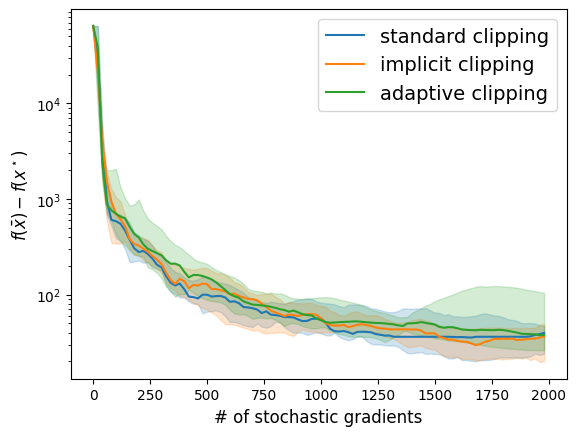

In [26]:
for p in params_list:
    opt_results = optimize_multiple_seeds(x_0, X, y, None, p, T, use_tqdm=True, with_iterates=False, opt=np.array(loss_scikit))
    mean, top, bottom = opt_results[2]
    mean, top, bottom = np.asnumpy(mean), np.asnumpy(top), np.asnumpy(bottom)
    plot_with_shaded_region(range(0,T,p.num_grads_per_step)[::resolution], mean[::resolution], top[::resolution], bottom[::resolution], p.name, color=p.plot_color)

    # opt_results = optimize_reg(x_0, X, y, None, p, T, use_tqdm=True, with_iterates=False, opt=np.array(loss_scikit))
    # graph = np.asnumpy(opt_results[2])
    # plt.plot(range(0,T,p.num_grads_per_step)[::resolution], graph[::resolution], label=p.name, color=p.plot_color)

plot_global_config("# of stochastic gradients", 12, r"$f(\bar{x}) - f(x^\star)$", 12, 14, 'figure0.pdf')
plt.show()

### clipping vs no clipping

In [27]:
params_list_clipped = [
    ClippedSGD(name="clipped SGD"),
    ClippedAdaptiveSGD(name="clipped AdaptiveSGD"),
]
params_list_unclipped = [
    SGD(name="SGD"),
    AdaptiveSGD(name="AdaptiveSGD"),
]

tune_reg(func,
         params_list_clipped[0],
         T,
         grid_lr=np.array(geomspace(1e-7, 1e-2, 6)),
         grid_c=np.array(geomspace(1e02, 1e07, 6)),
         has_threshold=True,
         verbose=False)
tune_reg(func,
         params_list_clipped[1],
         T,
         grid_lr=np.array(geomspace(1e-3, 1e02, 6)),
         grid_c=np.array(geomspace(1e02, 1e07, 6)),
         has_threshold=True,
         verbose=False)
tune_reg(func,
         params_list_unclipped[0],
         T,
         grid_lr=np.array(geomspace(1e-10, 1e-5, 6)),
         grid_c=None,
         has_threshold=False,
         verbose=False)
tune_reg(func,
         params_list_unclipped[1],
         T,
         grid_lr=np.array(geomspace(1e-2, 1e3, 6)),
         grid_c=None,
         has_threshold=False,
         verbose=False)

tuning clipped SGD...


100%|██████████| 36/36 [01:17<00:00,  2.16s/it]


    best (lr,c) from coarse search: (1.0e-06,1.0e+05)


100%|██████████| 25/25 [01:02<00:00,  2.48s/it]


    best (lr,c) from fine search: (4.0e-06,2.5e+04)
tuning clipped AdaptiveSGD...


100%|██████████| 36/36 [01:39<00:00,  2.76s/it]


    best (lr,c) from coarse search: (1.0e+01,1.0e+04)


100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


    best (lr,c) from fine search: (2.5e+00,4.0e+04)
tuning SGD...


100%|██████████| 6/6 [00:31<00:00,  5.33s/it]


    best (lr) from coarse search: (1.0e-06)


100%|██████████| 5/5 [00:26<00:00,  5.27s/it]


    best (lr) from fine search: (1.0e-06)
tuning AdaptiveSGD...


100%|██████████| 6/6 [00:33<00:00,  5.59s/it]


    best (lr) from coarse search: (1.0e+00)


100%|██████████| 5/5 [00:27<00:00,  5.53s/it]

    best (lr) from fine search: (1.0e+00)


In [28]:
clipped_results = [
    optimize_multiple_seeds(x_0, X, y, None, p, T, use_tqdm=True, with_iterates=False, opt=np.array(loss_scikit))
    for p in params_list_clipped
]
unclipped_results = [
    optimize_multiple_seeds(x_0, X, y, None, p, T, use_tqdm=True, with_iterates=False, opt=np.array(loss_scikit))
    for p in params_list_unclipped
]

100%|██████████| 10/10 [00:56<00:00,  5.65s/it]


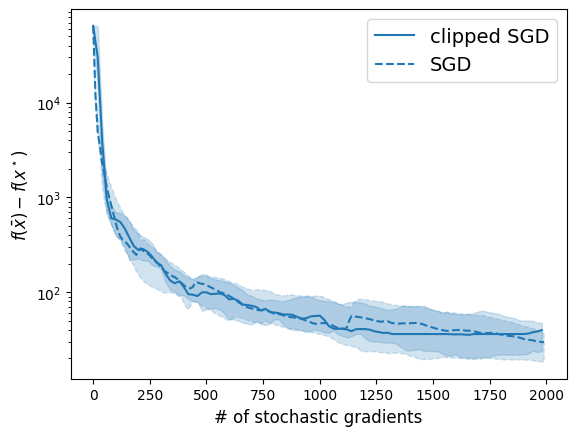

In [29]:
p = params_list_clipped[0]
mean, top, bottom = clipped_results[0][2]
mean, top, bottom = np.asnumpy(mean), np.asnumpy(top), np.asnumpy(bottom)
plot_with_shaded_region(range(0,T,p.num_grads_per_step)[::resolution], mean[::resolution], top[::resolution], bottom[::resolution], p.name, color=p.plot_color)

p = params_list_unclipped[0]
mean, top, bottom = unclipped_results[0][1]
mean, top, bottom = np.asnumpy(mean), np.asnumpy(top), np.asnumpy(bottom)
plot_with_shaded_region(range(0,T,p.num_grads_per_step)[::resolution], mean[::resolution], top[::resolution], bottom[::resolution], p.name, color=p.plot_color, linestyle='dashed')

plot_global_config("# of stochastic gradients", 12, r"$f(\bar{x}) - f(x^\star)$", 12, 14, 'figure1-1.pdf')
plt.show()

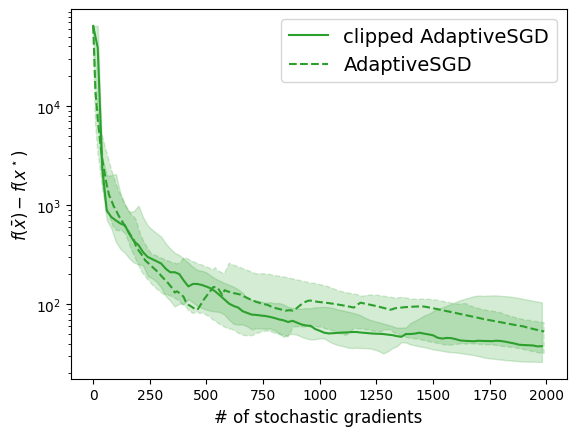

In [30]:
p = params_list_clipped[1]
mean, top, bottom = clipped_results[1][2]
mean, top, bottom = np.asnumpy(mean), np.asnumpy(top), np.asnumpy(bottom)
plot_with_shaded_region(range(0,T,p.num_grads_per_step)[::resolution], mean[::resolution], top[::resolution], bottom[::resolution], p.name, color=p.plot_color)

p = params_list_unclipped[1]
mean, top, bottom = unclipped_results[1][1]
mean, top, bottom = np.asnumpy(mean), np.asnumpy(top), np.asnumpy(bottom)
plot_with_shaded_region(range(0,T,p.num_grads_per_step)[::resolution], mean[::resolution], top[::resolution], bottom[::resolution], p.name, color=p.plot_color, linestyle='dashed')

plot_global_config("# of stochastic gradients", 12, r"$f(\bar{x}) - f(x^\star)$", 12, 14, 'figure1-2.pdf')
plt.show()

In [31]:
# for p in params_list_clipped:
#     opt_results = optimize_multiple_seeds(x_0, X, y, None, p, T, use_tqdm=True, with_iterates=False, opt=np.array(loss_scikit))
#     mean, top, bottom = opt_results[2]
#     mean, top, bottom = np.asnumpy(mean), np.asnumpy(top), np.asnumpy(bottom)
#     plot_with_shaded_region(range(0,T,p.num_grads_per_step)[::resolution], mean[::resolution], top[::resolution], bottom[::resolution], p.name, color=p.plot_color)
#     # opt_results = optimize_reg(x_0, func, p, T, use_tqdm=True, with_iterates=False, opt=np.array(loss_scikit))
#     # graph = np.asnumpy(opt_results[2])
#     # plt.plot(range(0,T,p.num_grads_per_step)[::resolution], graph[::resolution], label=p.name, color=p.plot_color)

# for p in params_list_unclipped:
#     opt_results = optimize_multiple_seeds(x_0, X, y, None, p, T, use_tqdm=True, with_iterates=False, opt=np.array(loss_scikit))
#     mean, top, bottom = opt_results[1]
#     mean, top, bottom = np.asnumpy(mean), np.asnumpy(top), np.asnumpy(bottom)
#     plot_with_shaded_region(range(0,T,p.num_grads_per_step)[::resolution], mean[::resolution], top[::resolution], bottom[::resolution], p.name, color=p.plot_color, linestyle='dashed')
#     # opt_results = optimize_reg(x_0, func, p, T, use_tqdm=True, with_iterates=False, opt=np.array(loss_scikit))
#     # graph = np.asnumpy(opt_results[1])
#     # plt.plot(range(0,T,p.num_grads_per_step)[::resolution], graph[::resolution], "--", label=p.name, color=p.plot_color)


# plot_global_config("# of stochastic gradients", 12, r"$f(\bar{x}) - f(x^\star)$", 12, 14, 'figure1.pdf')
# plt.show()

### single vs. double

In [32]:
params_list = [
    ClippedSGD(name="clipped SGD (double)"),
    ClippedSGDSingleSample(name="clipped SGD (single)"),
]
# in order to compare by iteration complexity (comparison by sample complexity is in the next plot)
params_list[0].num_grads_per_step = 1

tune_reg(func,
         params_list[0],
         T,
         grid_lr=np.array(geomspace(1e-7, 1e-2, 6)),
         grid_c=np.array(geomspace(1e02, 1e07, 6)),
         has_threshold=True,
         verbose=False)
tune_reg(func,
         params_list[1],
         T,
         grid_lr=np.array(geomspace(1e-7, 1e-2, 6)),
         grid_c=np.array(geomspace(1e02, 1e07, 6)),
         has_threshold=True,
         verbose=False)

tuning clipped SGD (double)...


100%|██████████| 36/36 [03:02<00:00,  5.07s/it]


    best (lr,c) from coarse search: (1.0e-06,1.0e+07)


100%|██████████| 25/25 [02:26<00:00,  5.87s/it]


    best (lr,c) from fine search: (1.0e-06,2.5e+06)
tuning clipped SGD (single)...


100%|██████████| 36/36 [03:05<00:00,  5.16s/it]


    best (lr,c) from coarse search: (1.0e-06,1.0e+05)


100%|██████████| 25/25 [02:35<00:00,  6.22s/it]

    best (lr,c) from fine search: (2.0e-06,1.0e+05)


100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


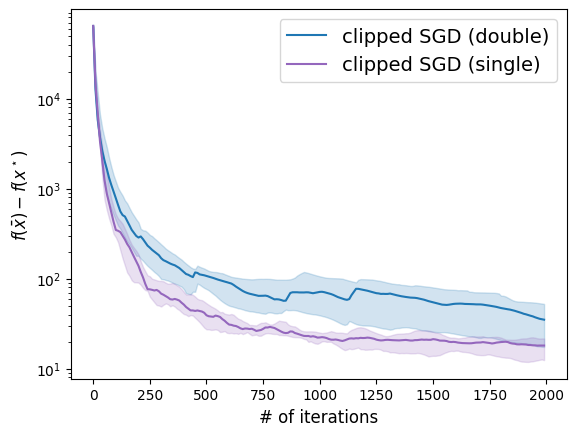

In [33]:
for p in params_list:
    opt_results = optimize_multiple_seeds(x_0, X, y, None, p, T, use_tqdm=True, with_iterates=False, opt=np.array(loss_scikit))
    mean, top, bottom = opt_results[2]
    mean, top, bottom = np.asnumpy(mean), np.asnumpy(top), np.asnumpy(bottom)
    plot_with_shaded_region(range(0,T,p.num_grads_per_step)[::resolution], mean[::resolution], top[::resolution], bottom[::resolution], p.name, color=p.plot_color)
    # opt_results = optimize_reg(x_0, func, p, T, use_tqdm=True, with_iterates=False, opt=np.array(loss_scikit))
    # graph = np.asnumpy(opt_results[2])
    # plt.plot(range(0,T,p.num_grads_per_step)[::resolution], graph[::resolution], label=p.name, color=p.plot_color)

plot_global_config("# of iterations", 12, r"$f(\bar{x}) - f(x^\star)$", 12, 14, 'figure2.pdf')
plt.show()

In [34]:
params_list = [
    ClippedSGD(name="clipped SGD (double)"),
    ClippedSGDSingleSample(name="clipped SGD (single)"),
]
tune_reg(func,
         params_list[0],
         T,
         grid_lr=np.array(geomspace(1e-8, 1e-3, 6)),
         grid_c=np.array(geomspace(1e02, 1e07, 6)),
         has_threshold=True,
         verbose=False)
tune_reg(func,
         params_list[1],
         T,
         grid_lr=np.array(geomspace(1e-8, 1e-3, 6)),
         grid_c=np.array(geomspace(1e02, 1e07, 6)),
         has_threshold=True,
         verbose=False)

tuning clipped SGD (double)...


100%|██████████| 36/36 [01:20<00:00,  2.22s/it]


    best (lr,c) from coarse search: (1.0e-06,1.0e+05)


100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


    best (lr,c) from fine search: (4.0e-06,2.5e+04)
tuning clipped SGD (single)...


100%|██████████| 36/36 [03:10<00:00,  5.30s/it]


    best (lr,c) from coarse search: (1.0e-06,1.0e+05)


100%|██████████| 25/25 [02:34<00:00,  6.20s/it]

    best (lr,c) from fine search: (2.0e-06,1.0e+05)


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


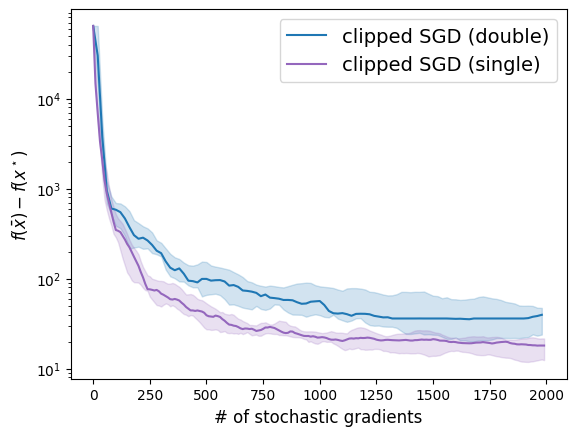

In [35]:
for p in params_list:
    opt_results = optimize_multiple_seeds(x_0, X, y, None, p, T, use_tqdm=True, with_iterates=False, opt=np.array(loss_scikit))
    mean, top, bottom = opt_results[2]
    mean, top, bottom = np.asnumpy(mean), np.asnumpy(top), np.asnumpy(bottom)
    plot_with_shaded_region(range(0,T,p.num_grads_per_step)[::resolution], mean[::resolution], top[::resolution], bottom[::resolution], p.name, color=p.plot_color)
    # opt_results = optimize_reg(x_0, func, p, T, use_tqdm=True, with_iterates=False, opt=np.array(loss_scikit))
    # graph = np.asnumpy(opt_results[2])
    # plt.plot(range(0,T,p.num_grads_per_step)[::resolution], graph[::resolution], label=p.name, color=p.plot_color)

plot_global_config("# of stochastic gradients", 12, r"$f(\bar{x}) - f(x^\star)$", 12, 14, 'figure3.pdf')
plt.show()

### average over $\{1,...,T\}$ vs. average over $\mathcal{T}_2$

In [36]:
params_list = [
    ClippedSGD(name=r"clipped SGD, $\mathcal{T}_2$ avg"),
    ClippedSGD(name="clipped SGD, regular avg"),
]
tune_reg(func,
         params_list[0],
         T,
         grid_lr=np.array(geomspace(1e-7, 1e-2, 6)),
         grid_c=np.array(geomspace(1e02, 1e07, 6)),
         has_threshold=True,
         verbose=False)
tune_reg(func,
         params_list[1],
         T,
         grid_lr=np.array(geomspace(1e-7, 1e-2, 6)),
         grid_c=np.array(geomspace(1e02, 1e07, 6)),
         has_threshold=True,
         verbose=False,
         criteria=1)

tuning clipped SGD, $\mathcal{T}_2$ avg...


100%|██████████| 36/36 [01:23<00:00,  2.31s/it]


    best (lr,c) from coarse search: (1.0e-06,1.0e+05)


100%|██████████| 25/25 [01:02<00:00,  2.49s/it]


    best (lr,c) from fine search: (4.0e-06,2.5e+04)
tuning clipped SGD, regular avg...


100%|██████████| 36/36 [01:18<00:00,  2.17s/it]


    best (lr,c) from coarse search: (1.0e-06,1.0e+07)


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]

    best (lr,c) from fine search: (1.0e-06,2.5e+06)


100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


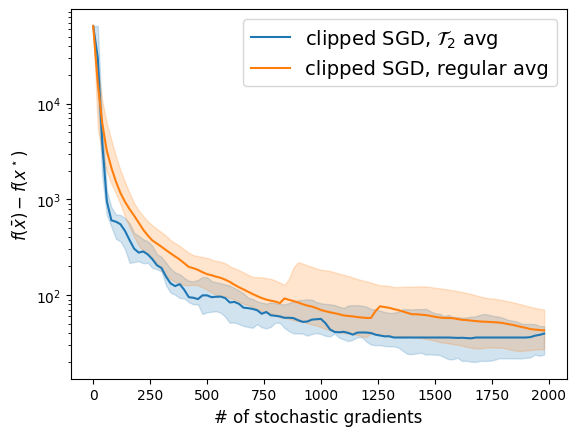

In [37]:
p = params_list[0]

opt_results = optimize_multiple_seeds(x_0, X, y, None, p, T, use_tqdm=True, with_iterates=False, opt=np.array(loss_scikit))
mean, top, bottom = opt_results[2]
mean, top, bottom = np.asnumpy(mean), np.asnumpy(top), np.asnumpy(bottom)
plot_with_shaded_region(range(0,T,p.num_grads_per_step)[::resolution], mean[::resolution], top[::resolution], bottom[::resolution], p.name, color=p.plot_color)
# opt_results = optimize_reg(x_0, func, p, T, use_tqdm=True, with_iterates=False, opt=np.array(loss_scikit))
# graph = np.asnumpy(opt_results[2])
# plt.plot(range(0,T,p.num_grads_per_step)[::resolution], graph[::resolution], label=p.name, color=p.plot_color)

p = params_list[1]

opt_results = optimize_multiple_seeds(x_0, X, y, None, p, T, use_tqdm=True, with_iterates=False, opt=np.array(loss_scikit))
mean, top, bottom = opt_results[1]
mean, top, bottom = np.asnumpy(mean), np.asnumpy(top), np.asnumpy(bottom)
plot_with_shaded_region(range(0,T,p.num_grads_per_step)[::resolution], mean[::resolution], top[::resolution], bottom[::resolution], p.name, color='tab:orange')
# opt_results = optimize_reg(x_0, func, p, T, use_tqdm=True, with_iterates=False, opt=np.array(loss_scikit))
# graph = np.asnumpy(opt_results[1])
# plt.plot(range(0,T,p.num_grads_per_step)[::resolution], graph[::resolution], label=p.name, color="tab:brown")

plot_global_config("# of stochastic gradients", 12, r"$f(\bar{x}) - f(x^\star)$", 12, 14, 'figure4.pdf')
plt.show()

### download the figures generated by the experiments

In [38]:
import os
from google.colab import files

all_files = os.listdir()
figure_files = [f for f in all_files if f.startswith("figure") and os.path.isfile(f)]

for f in figure_files:
    files.download(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>